## Pós graduação em inteligência artificial aplicada

### Alunos: Guilherme Oishi Feitosa e Renan Moraes
### Orientador: Johannes 

<h1 align="center"> Tema: Detecção de solonência usando deep learning </h1>

### Introdução ao problema

O problema abordado nesse trabalho será a detecção de sonolência já que este está diretamente relacionado a diversos tipos de acidentes principalmente acidentes de trânsito.

A sonolência é uma das grandes causadores de acidentes, principalmente acidentes de trânsito, segundo uma pesquisa realizada pela Associação Brasileira de Medicina de Tráfego (ABRAMET) em parceria com a Academia Brasileira de Neurologia e o Conselho Regional de Medicina indicou que cerca de 42% dos acidentes de trânsito estão relacionados ao sono (https://autopapo.uol.com.br/noticia/mais-de-40-dos-acidentes-de-transito-acontece-por-sonolencia-afirma-a-abramet/).

Segundo pesquisas dirigir com sono pode ser tão perigoso quanto dirigir alcoolizado (BATISTA, 2017). 

<img src="acidente_sono.jpg" width="500">

Com isso, acredita-se que se houver uma maneira de identificar e alertar o motorista no momento da sonolência, grande parte desses acidentes possam ser evitados.  

### Importando bibliotecas necessárias

In [140]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import models
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf

### Imagens utilizadas para treinar/testar os modelos

##### Para treinar o modelo foram utilizadas duas categorias de imagens
- Pessoas com os olhos abertos
- Pessoas com os olhos fechados

As imagens de pessoas com olhos abertos foram obtidas no link: https://cswww.essex.ac.uk/mv/allfaces/

Neste link há quatro datasets com fotos de faces de pessoas, a única diferente entre elas é o fundo da imagem, porém como este será removido posteriormente, foram utilizadas duas amostras de cada individuo dos datasets, apenas algumas imagens que apresentavam uma baixa qualidade não foram aproveitadas.

As imagens de pessoas com olhos fechados foram obtidas no link: http://parnec.nuaa.edu.cn/_upload/tpl/02/db/731/template731/pages/xtan/ClosedEyeDatabases.html

Neste link há um dataset contendo diversas imagens de pessoas com olhos fechados, porém esse dataset está um pouco bagunçado com algumas imagens de pessoas com olhos abertos, então foi necessária uma limpeza, foram removidos esses casos e também foram removidas fotos de crianças e algumas fotos que apresentavam baixa qualidade.

Além dos link apresentados acima, também foram utilizadas algumas fotos dos autores e de alguns amigos

### Definindo função que dado um diretório aplica uma segmentação de face em todas as imagens

In [58]:
def Corta_Face (diretorio, label):
    
    index = 1
    
    # Carregando o modelo de detecção
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

    # Iternado sobre todas as imagens da pasta
    for filename in os.listdir(diretorio):

        # Considerando apenas imagens com extensão .jpg
        if filename.endswith(".jpg"):

            # Mudando o diretório
            os.chdir(diretorio)

            # Lendo a imagem
            img = cv2.imread(filename, cv2.IMREAD_COLOR)

            # Convertendo em escala de cinza
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

            # Detectando o rosto
            faces = face_cascade.detectMultiScale(gray, 1.1, 2)

            if len(faces) != 0: 
                # Cortando o fundo da imagem, deixando apenas a região de interesse
                for (x, y, w, h) in faces:
                    face_crop = img[y:y+h, x:x+w]

                # Definindo nome da nova imagem
                new_filename = label + '_' + str(index) + '.jpg'

                # Ajustando a imagem para 100 x 100
                face_crop = cv2.resize(face_crop, (100, 100))

                # Salvando a imagem cortada
                cv2.imwrite(new_filename, face_crop)    

                # Removendo a imagem original da pasta
                os.remove(filename)

                index = index + 1

            else:
                # Removendo a imagem original da pasta
                os.remove(filename)

        else:
            continue

### Aplicando função corta face nas fotos de olho fechado

In [ ]:
# Definindo diretório que será aplicado
directory = r'C:\Users\R\Desktop\TCC- Pós\Fotos\Fotos olho fechado'

Corta_Face(directory, "olho_fechado")

### Aplicando função corta face nas fotos de olho aberto

In [ ]:
# Definindo diretório que será aplicado
directory = r'C:\Users\R\Desktop\TCC- Pós\Fotos\Fotos olho aberto'

Corta_Face(directory, "olho_aberto")

### Caregando os dados de treino

In [5]:
img_width, img_height = 100, 100

In [146]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=20,
                                   brightness_range=[0.5,1.0],
                                   zoom_range=0.05,
                                   fill_mode="nearest")

train_generator = train_datagen.flow_from_directory('Fotos_variadas/train/', 
                                                    target_size=(img_width, img_height),
                                                    class_mode='categorical',
                                                    color_mode='rgb',
                                                    batch_size=32,
                                                    shuffle=True)

Found 851 images belonging to 2 classes.


In [147]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory('Fotos_variadas/test/', 
                                                  target_size=(img_width, img_height),
                                                  class_mode='categorical', 
                                                  color_mode='rgb',
                                                  batch_size=32,
                                                  shuffle=True,)

Found 358 images belonging to 2 classes.


In [83]:
# Carrega o modelo sem as camadas de classificação
resnet_model = ResNet50(include_top=False, weights="imagenet", input_shape=(100, 100, 3))

# Define as camadas em que não será feito o treinamento
for layer in resnet_model.layers:
  layer.trainable = False
   
resnet_model.summary()

model = Sequential([
    resnet_model,
    Dropout(0.2),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(2, activation='softmax')
])

model.summary()

C:\Users\R\anaconda\envs\envtcc\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 50, 50, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
dropout_5 (Dropout)          (None, 4, 4, 2048)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              33555456  
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 2050      
Total params: 57,145,218
Trainable params: 33,557,506
Non-trainable params: 23,587,712
_________________________________________________________________


In [11]:
earlystopper = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=15, 
    mode='min', 
    verbose=1)

In [12]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.3, 
    patience=5, 
    min_lr=0, 
    verbose=1)

In [84]:
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [85]:
EPOCHS = 10

hist = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator
)

Epoch 1/10
27/27 [==============================] - 108s 4s/step - loss: 6.6838 - accuracy: 0.8508 - val_loss: 1.3550e-05 - val_accuracy: 0.8799
Epoch 2/10
27/27 [==============================] - 106s 4s/step - loss: 0.2088 - accuracy: 0.9694 - val_loss: 0.0000e+00 - val_accuracy: 0.9385
Epoch 3/10
27/27 [==============================] - 108s 4s/step - loss: 0.2293 - accuracy: 0.9812 - val_loss: 0.0000e+00 - val_accuracy: 0.9218
Epoch 4/10
27/27 [==============================] - 105s 4s/step - loss: 0.0912 - accuracy: 0.9800 - val_loss: 0.0035 - val_accuracy: 0.9497
Epoch 5/10
27/27 [==============================] - 96s 4s/step - loss: 0.0892 - accuracy: 0.9871 - val_loss: 5.0827 - val_accuracy: 0.8603
Epoch 6/10
27/27 [==============================] - 95s 4s/step - loss: 0.0511 - accuracy: 0.9894 - val_loss: 1.2031 - val_accuracy: 0.8575
Epoch 7/10
27/27 [==============================] - 95s 4s/step - loss: 0.0551 - accuracy: 0.9906 - val_loss: 0.4604 - val_accuracy: 0.8464
Epoc

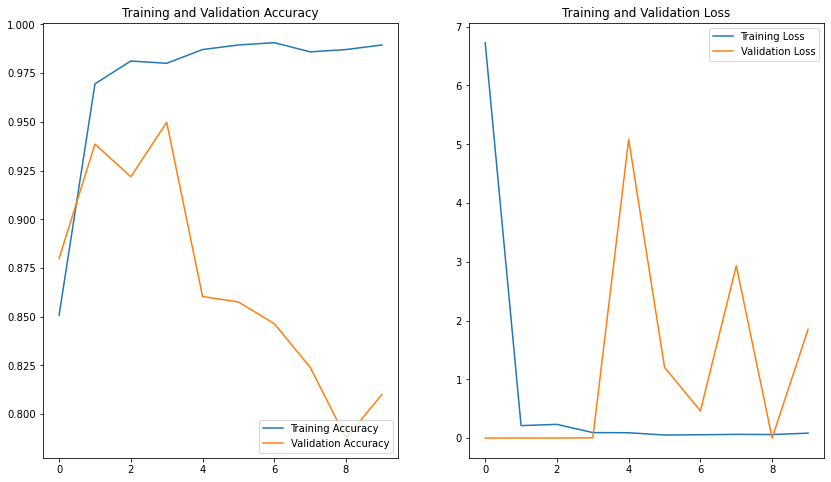

In [86]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save("resnet_imagenet")

In [ ]:
scores = model.evaluate_generator(generator=test_generator,
steps=np.ceil(364/64))

print("Accuracy = ", scores[1])

In [112]:
# Carrega o modelo sem as camadas de classificação
xception = Xception(include_top=False, weights="imagenet", input_shape=(100, 100, 3))

# Define as camadas em que não será feito o treinamento
for layer in xception.layers:
  layer.trainable = False
   
xception.summary()

xception_model = Sequential([
    xception,
    Dropout(0.3),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(2, activation='softmax')
])

xception_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 49, 49, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 49, 49, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 49, 49, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 3, 3, 2048)        20861480  
_________________________________________________________________
dropout_6 (Dropout)          (None, 3, 3, 2048)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              18875392  
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 2050      
Total params: 39,738,922
Trainable params: 18,877,442
Non-trainable params: 20,861,480
_________________________________________________________________


In [113]:
xception_model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [114]:
EPOCHS = 5

hist = xception_model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator
)

Epoch 1/5
27/27 [==============================] - 90s 3s/step - loss: 2.0352 - accuracy: 0.7474 - val_loss: 24.4830 - val_accuracy: 0.4274
Epoch 2/5
15/27 [===============>..............] - ETA: 30s - loss: 0.5131 - accuracy: 0.8792

KeyboardInterrupt: 

In [ ]:
xception_model.save("xception_imagenet")

In [149]:
# Carrega o modelo sem as camadas de classificação
mobile_net = MobileNet(include_top=False, weights="imagenet", input_shape=(100, 100, 3))

# Define as camadas em que não será feito o treinamento
for layer in mobile_net.layers:
  layer.trainable = False
   
mobile_net.summary()

mobile_net_model = Sequential([
    mobile_net,
    Dropout(0.2),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(2, activation='softmax')
])

mobile_net_model.summary()

C:\Users\R\anaconda\envs\envtcc\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 100, 100, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 101, 101, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 50, 50, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 50, 50, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 50, 50, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 50, 50, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 50, 50, 32) 

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 3, 3, 1024)        3228864   
_________________________________________________________________
dropout_10 (Dropout)         (None, 3, 3, 1024)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 9216)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               2359552   
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 514       
Total params: 5,588,930
Trainable params: 2,360,066
Non-trainable params: 3,228,864
_________________________________________________________________


In [144]:
mobile_net_model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [145]:
EPOCHS = 20

hist = mobile_net_model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    callbacks=[earlystopper, reduce_lr]
)

Epoch 1/20
27/27 [==============================] - 100s 4s/step - loss: 14.6875 - accuracy: 0.8519 - val_loss: 32.0226 - val_accuracy: 0.5140
Epoch 2/20
 9/27 [=========>....................] - ETA: 56s - loss: 0.2305 - accuracy: 0.9826 

KeyboardInterrupt: 

In [22]:
mobile_net_model.save("mobile_net_imagenet")

In [ ]:
# Carrega o modelo sem as camadas de classificação
inception_v3 = InceptionV3(include_top=False, weights="imagenet", input_shape=(100, 100, 3))
#resnet_model = ResNet50(include_top=False, input_shape=(100, 100, 3))

# Define as camadas em que não será feito o treinamento
for layer in inception_v3.layers:
  layer.trainable = False
   
inception_v3.summary()

inception_v3_model = Sequential([
    inception_v3,
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(2, activation='softmax')
])

inception_v3_model.summary()

In [ ]:
inception_v3_model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [ ]:
EPOCHS = 20

hist = inception_v3_model.fit_generator(
    train_generator,
    steps_per_epoch=np.ceil(851/32),
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=np.ceil(358/32),
    callbacks=[earlystopper, reduce_lr]
)

In [ ]:
inception_v3_model.save("inception_v3_imagenet")

In [ ]:
# Carrega o modelo sem as camadas de classificação
resenet_v2 = ResNet50V2(include_top=False, weights="imagenet", input_shape=(100, 100, 3))
#resnet_model = ResNet50(include_top=False, input_shape=(100, 100, 3))

# Define as camadas em que não será feito o treinamento
for layer in resenet_v2.layers:
  layer.trainable = False
   
resenet_v2.summary()

resenet_v2_model = Sequential([
    resenet_v2,
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(2, activation='softmax')
])

resenet_v2_model.summary()

In [ ]:
resenet_v2_model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [ ]:
EPOCHS = 20

hist = resenet_v2_model.fit_generator(
    train_generator,
    steps_per_epoch=np.ceil(851/32),
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=np.ceil(358/32),
    callbacks=[earlystopper, reduce_lr]
)

In [ ]:
resenet_v2_model.save("resenet_v2_imagenet")

### Fazendo predição 

In [60]:
# Definindo diretório que será aplicado
directory = r'C:\Users\R\Desktop\TCC- Pós\corta'

Corta_Face(directory, "predict")

In [65]:
os.chdir(r'C:\Users\R\Desktop\TCC- Pós')

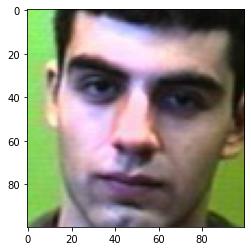

In [141]:
# Carrega a imagem
image_original = load_img('predict/predict_4.jpg', target_size=(100, 100))
plt.imshow(image_original);plt.show()

In [142]:
# Converte a imagem em um array
image = img_to_array(image_original)

img_array = tf.expand_dims(image, 0)

# Prepara a imagem de entrada para o VGG16
#image = preprocess_input(image)

In [144]:
pred = model.predict(img_array)
print(pred)

ValueError: If your data is in the form of symbolic tensors, you should specify the `steps` argument (instead of the `batch_size` argument, because symbolic tensors are expected to produce batches of input data).

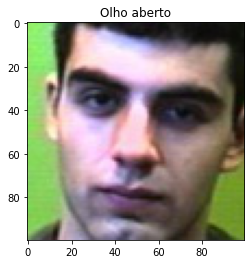

In [139]:
# Prediz a probabilidade dentre todas as classes
pred = model.predict_classes(image)

if pred[0] == 0:
    plt.imshow(image_original);plt.title('Olho aberto');plt.show()   
else:
    plt.imshow(image_original);plt.title('Olho fechado');plt.show()  

### Data Augumentation

In [113]:
train_datagen = ImageDataGenerator(rotation_range=20,
                                   brightness_range=[0.5,1.0],
                                   zoom_range=0.05,
                                   fill_mode="nearest")

train_generator = train_datagen.flow_from_directory('image/', 
                                                    target_size=(img_width, img_height),
                                                    class_mode='categorical',
                                                    color_mode='rgb',
                                                    batch_size=32)    


Found 1 images belonging to 1 classes.


In [61]:
image_original = load_img('image/exemplo/exemplo.jpg', target_size=(100, 100))

In [26]:
type(train_generator)

keras.preprocessing.image.DirectoryIterator

In [30]:
train_generator.filepaths[0]

'Fotos_variadas/train/Olho aberto\\olho_aberto_1.jpg'

In [31]:
image = load_img(train_generator.filepaths[0], target_size=(100, 100))

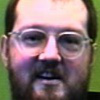

In [32]:
image

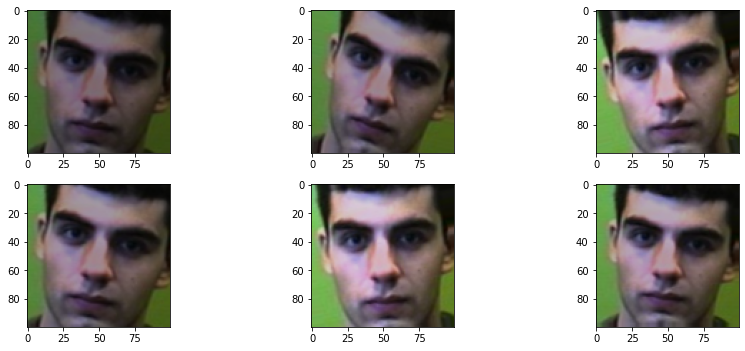

In [118]:
plt.figure(figsize=(12,12))
for i in range(0,6):
    plt.subplot(5, 3, i+1)
    batch = train_generator.next()
    plt.imshow(batch[0][0].astype('uint8'))
plt.tight_layout()
plt.show()

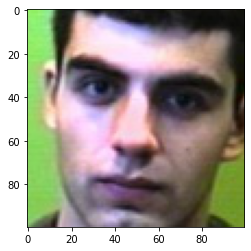

In [106]:
plt.imshow(load_img('image/exemplo/exemplo.jpg', target_size=(100, 100)))

### Criando uma rede convolucional simples

In [117]:
model = Sequential()
model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(100,100,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [118]:
EPOCHS = 10

hist = model.fit_generator(
    train_generator,
    steps_per_epoch=54,
    epochs=EPOCHS,
    validation_data=test_generator
)

Epoch 1/10
54/54 [==============================] - 21s 398ms/step - loss: 0.2971 - accuracy: 0.8796 - val_loss: 0.3047 - val_accuracy: 0.9637
Epoch 2/10
54/54 [==============================] - 21s 391ms/step - loss: 0.0925 - accuracy: 0.9647 - val_loss: 9.8783e-04 - val_accuracy: 0.9665
Epoch 3/10
54/54 [==============================] - 23s 425ms/step - loss: 0.0877 - accuracy: 0.9724 - val_loss: 0.0387 - val_accuracy: 0.9609
Epoch 4/10
54/54 [==============================] - 22s 408ms/step - loss: 0.0770 - accuracy: 0.9718 - val_loss: 0.0038 - val_accuracy: 0.9777
Epoch 5/10
54/54 [==============================] - 21s 383ms/step - loss: 0.0681 - accuracy: 0.9741 - val_loss: 0.0103 - val_accuracy: 0.9665
Epoch 6/10
54/54 [==============================] - 21s 395ms/step - loss: 0.0517 - accuracy: 0.9794 - val_loss: 2.1000e-05 - val_accuracy: 0.9721
Epoch 7/10
54/54 [==============================] - 23s 422ms/step - loss: 0.0391 - accuracy: 0.9824 - val_loss: 8.5433e-07 - val_accu

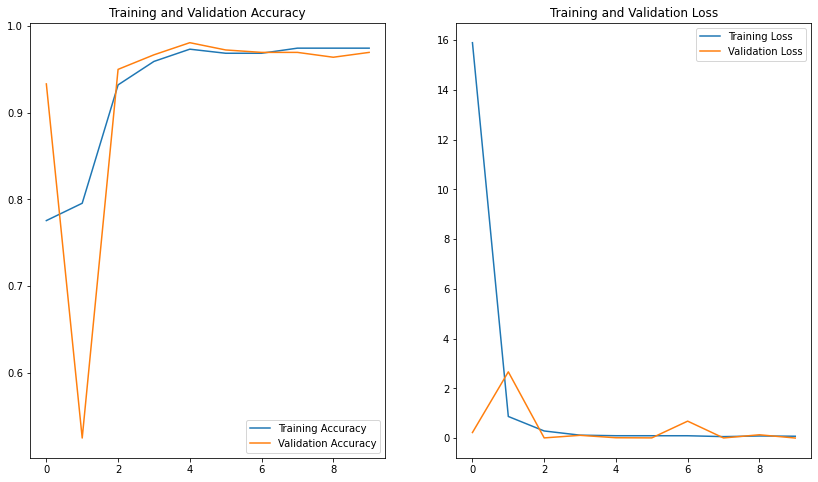

In [10]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()